In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import chi2_contingency

Read the Expression + mutation dataframe

In [2]:
df = pd.read_csv('/work/iku/exp1019-cancer-epigenetics-and-ervs/00_mut_and_ERV/results/03_add_ervs/with_ervs.tsv', sep = '\t')
#print(df.head())
print(list(df.columns))
#print(df.info())
#2581

['Dnmt3a', 'Dnmt3a_HIGH', 'Dnmt3a_MODERATE', 'Dnmt3a_LOW', 'Dnmt3a_MODIFIER', 'Dnmt1', 'Dnmt1_HIGH', 'Dnmt1_MODERATE', 'Dnmt1_LOW', 'Dnmt1_MODIFIER', 'Dnmt3b', 'Dnmt3b_HIGH', 'Dnmt3b_MODERATE', 'Dnmt3b_LOW', 'Dnmt3b_MODIFIER', 'Dnmt3L', 'Dnmt3L_HIGH', 'Dnmt3L_MODERATE', 'Dnmt3L_LOW', 'Dnmt3L_MODIFIER', 'Tet1', 'Tet1_HIGH', 'Tet1_MODERATE', 'Tet1_LOW', 'Tet1_MODIFIER', 'Tet2', 'Tet2_HIGH', 'Tet2_MODERATE', 'Tet2_LOW', 'Tet2_MODIFIER', 'Tet3', 'Tet3_HIGH', 'Tet3_MODERATE', 'Tet3_LOW', 'Tet3_MODIFIER', 'total_mut', 'patient_ID', 'filename', 'ERV_breadth', 'ERV_abundance', 'patient_ID_expr']


Filter out all non-Mutect2 annotated rows

In [3]:
def filter_non_mutect(filename):
    if 'MuTect2'in filename:
        return True
    else:
        return False

df['is_Mutect'] = df['filename'].apply(filter_non_mutect)
 
mutect_df = df[df['is_Mutect'] == True]
print(mutect_df.info())
#645 rows
                           
    

<class 'pandas.core.frame.DataFrame'>
Index: 645 entries, 3 to 2579
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Dnmt3a           645 non-null    int64  
 1   Dnmt3a_HIGH      645 non-null    int64  
 2   Dnmt3a_MODERATE  645 non-null    int64  
 3   Dnmt3a_LOW       645 non-null    int64  
 4   Dnmt3a_MODIFIER  645 non-null    int64  
 5   Dnmt1            645 non-null    int64  
 6   Dnmt1_HIGH       645 non-null    int64  
 7   Dnmt1_MODERATE   645 non-null    int64  
 8   Dnmt1_LOW        645 non-null    int64  
 9   Dnmt1_MODIFIER   645 non-null    int64  
 10  Dnmt3b           645 non-null    int64  
 11  Dnmt3b_HIGH      645 non-null    int64  
 12  Dnmt3b_MODERATE  645 non-null    int64  
 13  Dnmt3b_LOW       645 non-null    int64  
 14  Dnmt3b_MODIFIER  645 non-null    int64  
 15  Dnmt3L           645 non-null    int64  
 16  Dnmt3L_HIGH      645 non-null    int64  
 17  Dnmt3L_MODERATE  645

Expression distribution histograms (breadth & abundance) 

In [4]:
sns.set_theme()

In [5]:
mutect_df = mutect_df.copy()
#drop rows with NaN values (those we didn't find the expression file for)
print(' number of patients without expression file found: ', mutect_df.isna().any(axis=1).sum())
mutect_df = mutect_df.dropna(axis=0)
print('number of patients with expression file: ', len(mutect_df))

 number of patients without expression file found:  211
number of patients with expression file:  434


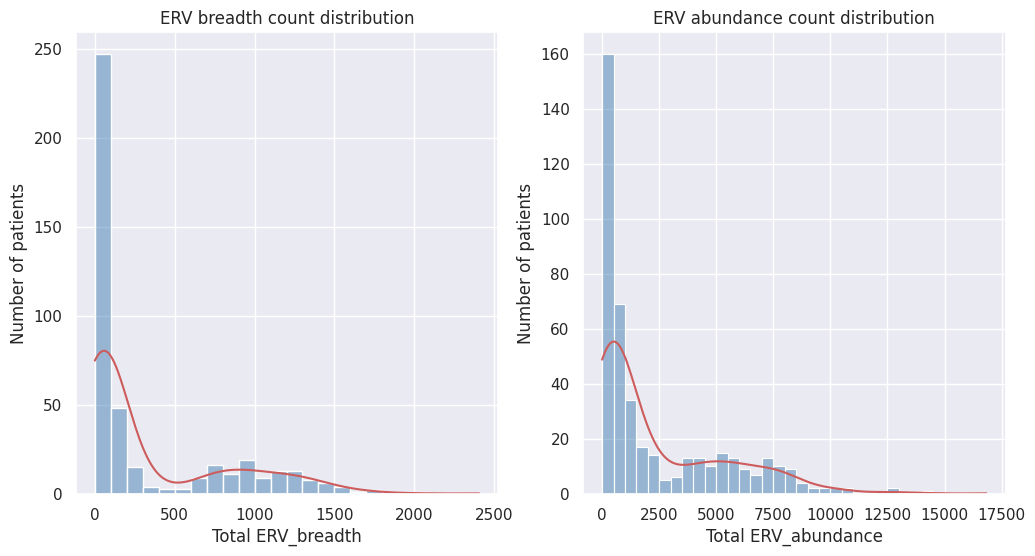

In [6]:
#ORIGINAL PLOT
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing code for creating distribution plots
bins = [x for x in range(0, 2300, 100)]
bins2 = [x for x in range(0, 15000, 500)]

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot ERV_breadth distribution on the first subplot
xx = sns.histplot(data=mutect_df, x="ERV_breadth", kde=True, bins=bins, ax=axes[0], color='steelblue')
xx.lines[0].set_color('indianred')
axes[0].set_xlabel("Total ERV_breadth")
axes[0].set_ylabel("Number of patients")
axes[0].set_title("ERV breadth count distribution")

# Plot ERV_abundance distribution on the second subplot
yy = sns.histplot(data=mutect_df, x="ERV_abundance", kde=True, bins=bins2, ax=axes[1], color='steelblue')
yy.lines[0].set_color('indianred')
axes[1].set_xlabel("Total ERV_abundance")
axes[1].set_ylabel("Number of patients")
axes[1].set_title("ERV abundance count distribution")

# Save the combined plot
plt.savefig('ERV_distribution_combined.png', dpi = 300)

# Show the combined plot
plt.show()


In [7]:
mutect_df = mutect_df.copy()
#drop rows with NaN values (those we didn't find the expression file for)
print(' number of patients without expression file found: ', mutect_df.isna().any(axis=1).sum())
mutect_df = mutect_df.dropna(axis=0)
print('number of patients with expression file: ', len(mutect_df))


 number of patients without expression file found:  0
number of patients with expression file:  434


In [8]:
def get_cancer_type(filename):
    pattern = r'^([^.]+)'
    match = re.match(pattern, filename)
    return match.group(1)
    

SPLIT THE DATAFRAMES BASED ON THE CANCER TYPE AND CLASSIFY HERV'S USING THE HIGH EXPRESSION BREADTH AND ABUNDANCE THRESHOLDS

In [15]:
mutect_df_cp = mutect_df.copy()

breadth_threshold = 400
abundance_threshold = 3000

mutect_df_cp['high_expr_breadth'] = np.where(mutect_df_cp['ERV_breadth'] > breadth_threshold, 'high ERV expression', 'low ERV expression')
mutect_df_cp['high_expr_abundance'] = np.where(mutect_df_cp['ERV_abundance'] > abundance_threshold, 'high ERV expression', 'low ERV expression')
mutect_df_cp['cancer_type'] = mutect_df_cp['filename'].apply(get_cancer_type)

#CREATE SEPARATE DF'S FOR DIFFERENT CANCER TYPES
LAML = mutect_df_cp[mutect_df_cp['cancer_type'] == 'TCGA_LAML']
STAD = mutect_df_cp[mutect_df_cp['cancer_type'] == 'TCGA_STAD']
DLBC = mutect_df_cp[mutect_df_cp['cancer_type'] == 'TCGA_DLBC']

#print(LAML.head())
#print(STAD.head())
#print(DLBC.head())


print(len(LAML[LAML['high_expr_abundance'] == 'high ERV expression']))

117


In [16]:
#get only the columns of interest 
DNMT3A_plot = mutect_df_cp[['Dnmt3a_HIGH', 'high_expr_abundance', 'high_expr_breadth', 'cancer_type']]
DNMT1_plot = mutect_df_cp[['Dnmt1_HIGH', 'high_expr_abundance', 'high_expr_breadth', 'cancer_type']]
DNMT3B_plot = mutect_df_cp[['Dnmt3b_HIGH', 'high_expr_abundance', 'high_expr_breadth', 'cancer_type']]
DNMT3L_plot = mutect_df_cp[['Dnmt3L_HIGH', 'high_expr_abundance', 'high_expr_breadth', 'cancer_type']]
TET1_plot = mutect_df_cp[['Tet1_HIGH', 'high_expr_abundance', 'high_expr_breadth', 'cancer_type']]
TET2_plot = mutect_df_cp[['Tet2_HIGH', 'high_expr_abundance', 'high_expr_breadth', 'cancer_type']]
TET3_plot = mutect_df_cp[['Tet3_HIGH', 'high_expr_abundance', 'high_expr_breadth', 'cancer_type']]


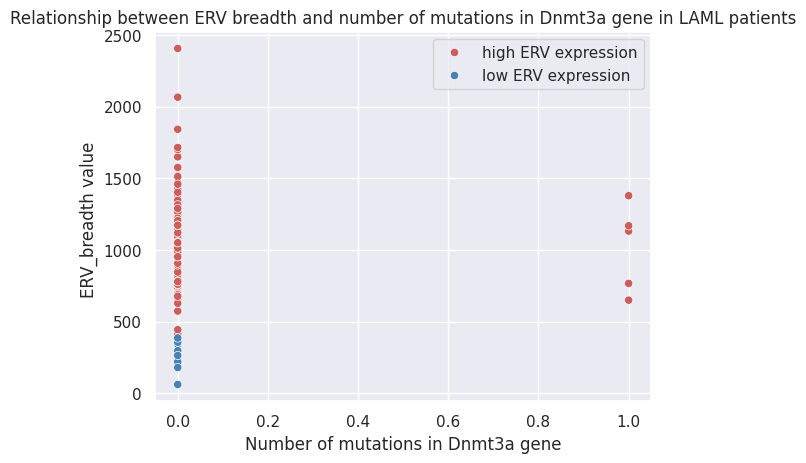

In [19]:
 # Set a custom color palette
custom_palette = {"high ERV expression": "indianred", "low ERV expression": "steelblue"}

#Dnmt3a_HIGH vs ERV_breadth
sns.scatterplot(data=LAML, x="Dnmt3a_HIGH", y="ERV_breadth", hue= 'high_expr_breadth', palette=custom_palette)
plt.title("Relationship between ERV breadth and number of mutations in Dnmt3a gene in LAML patients")
plt.xlabel("Number of mutations in Dnmt3a gene")
plt.ylabel("ERV_breadth value ")
#plt.xticks([0, 1])
plt.legend()

ValueError: The palette dictionary is missing keys: {'high ERV expression', 'low ERV expression'}

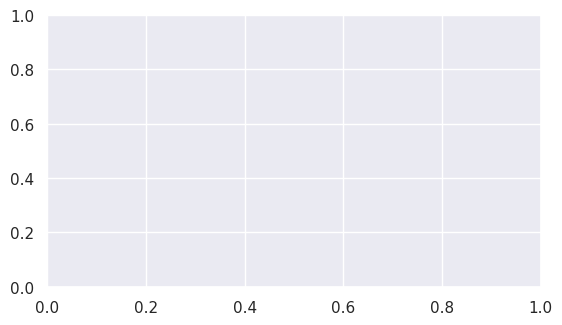

In [20]:
# Set a custom color palette
custom_palette = {"high expression": "indianred", "low expression": "steelblue"}

# Create a figure with multiple subplots
plt.figure(figsize=(14, 12))

# Dnmt3a_HIGH vs ERV_breadth
plt.subplot(3, 2, 1)
sns.scatterplot(data=LAML, x="Dnmt3a_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt3a_HIGH vs ERV_breadth LAML patients")
plt.xlabel("Number of mutations in Dnmt3a gene")
plt.ylabel("ERV_breadth")
#plt.xticks([0, 1])
plt.legend()

# Dnmt3a_HIGH vs ERV_abundance
plt.subplot(3, 2, 2)
sns.scatterplot(data=LAML, x="Dnmt3a_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3a_HIGH vs ERV_abundance LAML patients")
plt.xlabel("Number of mutations in Dnmt3a gene")
plt.ylabel("ERV_abundance")
#plt.xticks([0, 1])
plt.legend()

# Dnmt3a_MODERATE vs ERV_breadth
plt.subplot(3, 2, 3)
sns.scatterplot(data=STAD, x="Dnmt3a_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt3a_HIGH vs ERV_breadth STAD patients")
plt.xlabel("Number of mutations in Dnmt3a gene")
plt.ylabel("ERV_breadth")
#plt.xticks([0, 1])
plt.legend()

# Dnmt3a_MODERATE vs ERV_abundance
plt.subplot(3, 2, 4)
sns.scatterplot(data=STAD, x="Dnmt3a_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3a_HIGH vs ERV_abundance STAD patients")
plt.xlabel("Number of mutations in Dnmt3a gene")
plt.ylabel("ERV_abundance")
#plt.xticks([0, 1])
plt.legend()

# Dnmt3a_MODIFIER vs ERV_breadth
plt.subplot(3, 2, 5)
sns.scatterplot(data=DLBC, x="Dnmt3a_HIGH", y="ERV_breadth", hue="ER", palette=custom_palette)
plt.title("Dnmt3a_HIGH vs ERV_breadth DLBC patients")
plt.xlabel("Number of mutations in Dnmt3a gene")
plt.ylabel("ERV_breadth")
#plt.xticks([0, 1])
plt.legend()

# Dnmt3a_MODIFIER vs ERV_abundance
plt.subplot(3, 2, 6)
sns.scatterplot(data=DLBC, x="Dnmt3a_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3a_HIGH vs ERV_abundance DLBC patients")
plt.xlabel("Number of mutations in Dnmt3a gene")
plt.ylabel("ERV_abundance")
#plt.xticks([0, 1])
plt.legend()

    # Add row titles
#plt.text(-0.1, 8, "LAML", fontsize=14)
#plt.text(-2.5, 5, "STAD", fontsize=14)
#plt.text(-2.5, 9, "DLBC", fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("scatterplot_figure.png")

# Show the plots
plt.show()



ValueError: The palette dictionary is missing keys: {'high ERV expression', 'low ERV expression'}

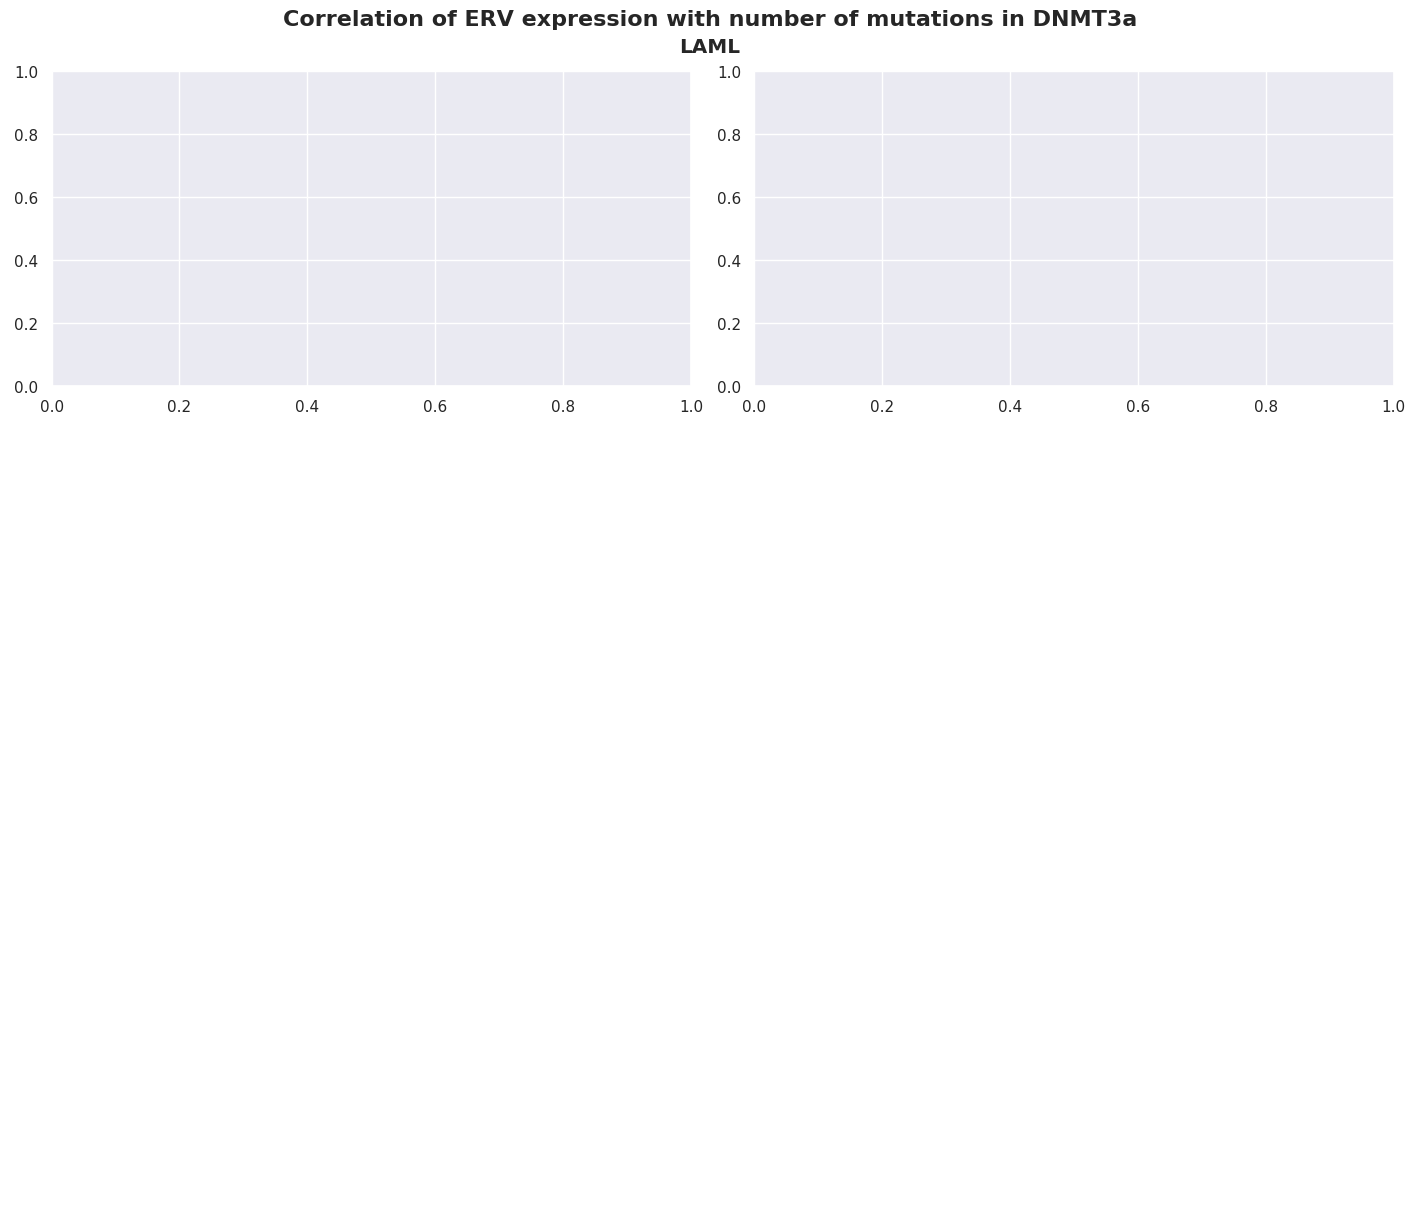

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data stored in 'cancer_data' dictionary
cancer_data = {'LAML': LAML, 'STAD': STAD, 'DLBC': DLBC}

# Set a custom color palette
custom_palette = {"high expression": "red", "low expression": "blue"}

# Create the main figure
fig = plt.figure(constrained_layout=True, figsize=(14, 12))
fig.suptitle('Correlation of ERV expression with number of mutations in DNMT3a', fontsize=16, fontweight="bold")

# Create 3x1 subfigures
subfigs = fig.subfigures(nrows=3, ncols=1)

# Iterate over each subfigure and create 1x3 subplots
for row, (cancer_type, data) in enumerate(cancer_data.items()):
    subfig = subfigs[row]
    subfig.suptitle(cancer_type, fontweight="bold")

    # Create 1x2 subplots per subfigure
    axs = subfig.subplots(nrows=1, ncols=2)
    
    # Plot Dnmt3a_HIGH vs ERV_breadth
    sns.scatterplot(data=data, x="Dnmt3a_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette, ax=axs[0])
    axs[0].set_title('Dnmt3a_HIGH vs ERV_breadth')
    axs[0].set_xlabel('Number of mutations in Dnmt3a gene')
    axs[0].set_ylabel('ERV_breadth')
    axs[0].legend()

    # Plot Dnmt3a_HIGH vs ERV_abundance
    sns.scatterplot(data=data, x="Dnmt3a_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette, ax=axs[1])
    axs[1].set_title('Dnmt3a_HIGH vs ERV_abundance')
    axs[1].set_xlabel('Number of mutations in Dnmt3a gene')
    axs[1].set_ylabel('ERV_abundance')
    axs[1].legend()
plt.savefig('DNMT3a_mutations.jpg')
plt.show()



In [ ]:
#cont how many patients with high impact mutation and high expression level 
he_hm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Tet2_HIGH"] != 0)).sum()
le_hm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Tet2_HIGH"] != 0)).sum()
he_lm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Tet2_HIGH"] == 0)).sum()
le_lm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Tet2_HIGH"] == 0)).sum()
print(he_hm, le_hm, he_lm, le_lm)

#perform the Chisq test
contingency_table = np.array([[le_hm, he_hm],[le_lm, he_lm]])
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print(f"Contingency Table (NumPy array):\n{contingency_table}")
print(f"\nChi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")



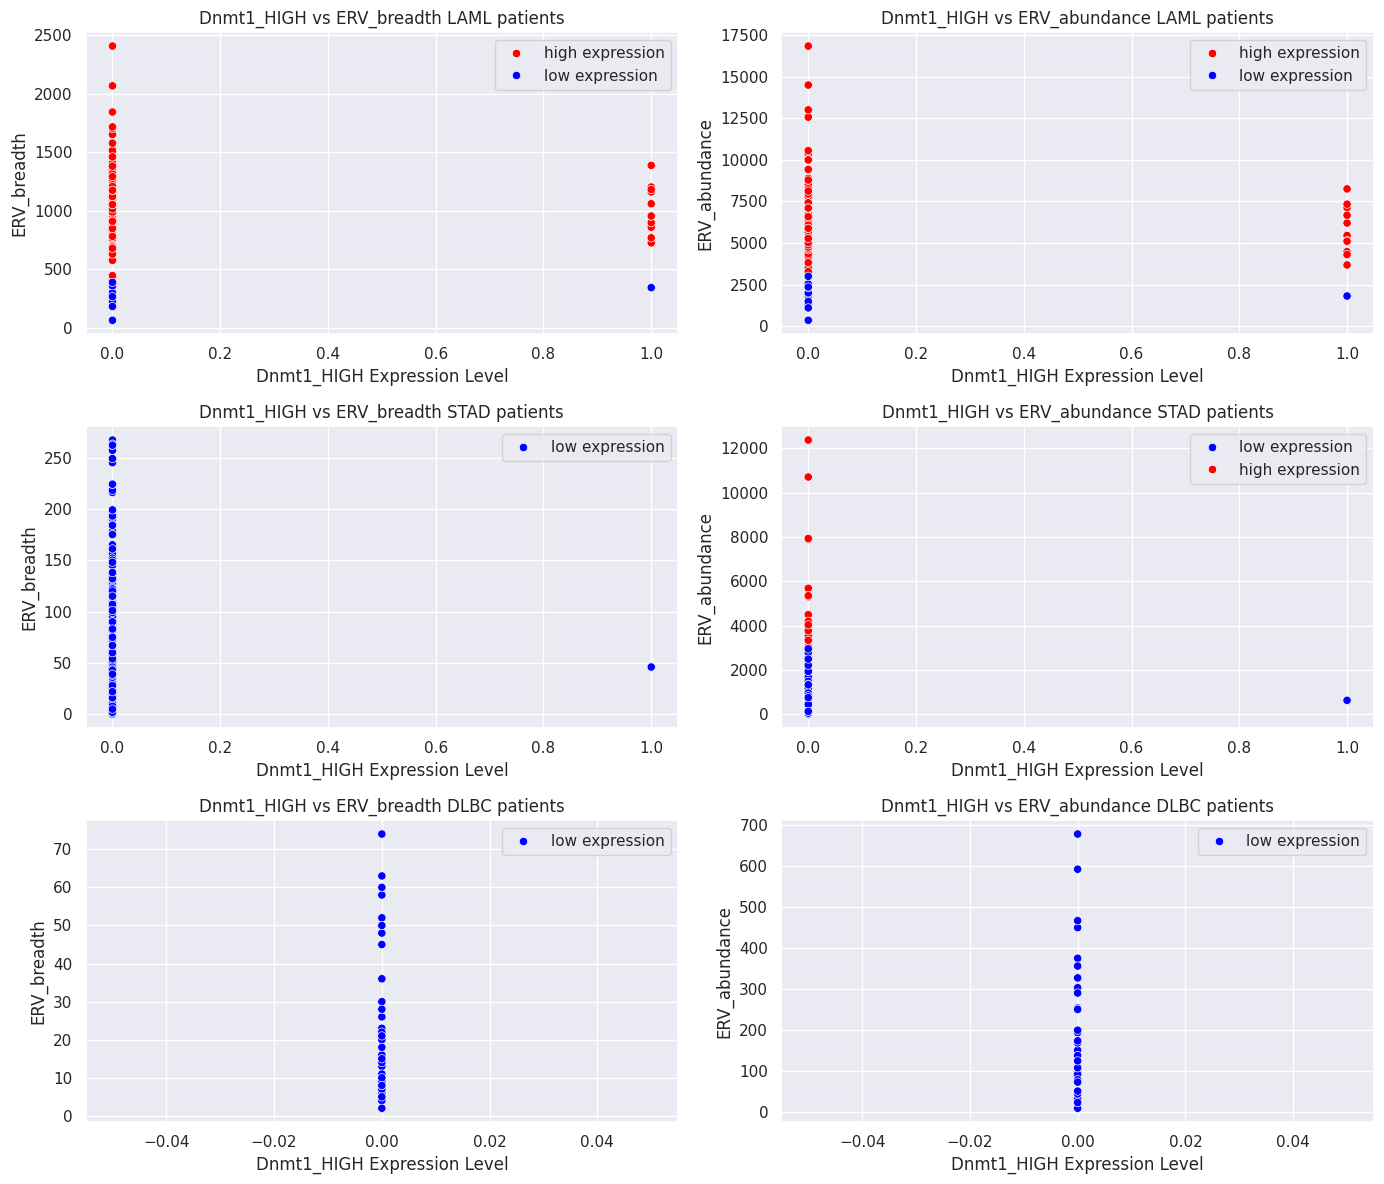

In [11]:
# Set a custom color palette
custom_palette = {"high expression": "red", "low expression": "blue"}

# Create a figure with multiple subplots
plt.figure(figsize=(14, 12))

# Dnmt1_HIGH vs ERV_breadth
plt.subplot(3, 2, 1)
sns.scatterplot(data=LAML, x="Dnmt1_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt1_HIGH vs ERV_breadth LAML patients")
plt.xlabel("Dnmt1_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt1_HIGH vs ERV_abundance
plt.subplot(3, 2, 2)
sns.scatterplot(data=LAML, x="Dnmt1_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt1_HIGH vs ERV_abundance LAML patients")
plt.xlabel("Dnmt1_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Dnmt1_MODERATE vs ERV_breadth
plt.subplot(3, 2, 3)
sns.scatterplot(data=STAD, x="Dnmt1_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt1_HIGH vs ERV_breadth STAD patients")
plt.xlabel("Dnmt1_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt1_MODERATE vs ERV_abundance
plt.subplot(3, 2, 4)
sns.scatterplot(data=STAD, x="Dnmt1_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt1_HIGH vs ERV_abundance STAD patients")
plt.xlabel("Dnmt1_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Dnmt1_MODIFIER vs ERV_breadth
plt.subplot(3, 2, 5)
sns.scatterplot(data=DLBC, x="Dnmt1_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt1_HIGH vs ERV_breadth DLBC patients")
plt.xlabel("Dnmt1_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt1_MODIFIER vs ERV_abundance
plt.subplot(3, 2, 6)
sns.scatterplot(data=DLBC, x="Dnmt1_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt1_HIGH vs ERV_abundance DLBC patients")
plt.xlabel("Dnmt1_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [12]:
#cont how many patients with high impact mutation and high expression level 
he_hm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Dnmt1_HIGH"] == 1)).sum()
le_hm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Dnmt1_HIGH"] == 1)).sum()
he_lm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Dnmt1_HIGH"] == 0)).sum()
le_lm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Dnmt1_HIGH"] == 0)).sum()
print(he_hm, le_hm, he_lm, le_lm)

#perform the Chisq test
contingency_table = np.array([[le_hm, he_hm],[le_lm, he_lm]])
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print(f"Contingency Table (NumPy array):\n{contingency_table}")
print(f"\nChi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")



13 1 107 8
Contingency Table (NumPy array):
[[  1  13]
 [  8 107]]

Chi-square Statistic: 0.0
P-value: 1.0


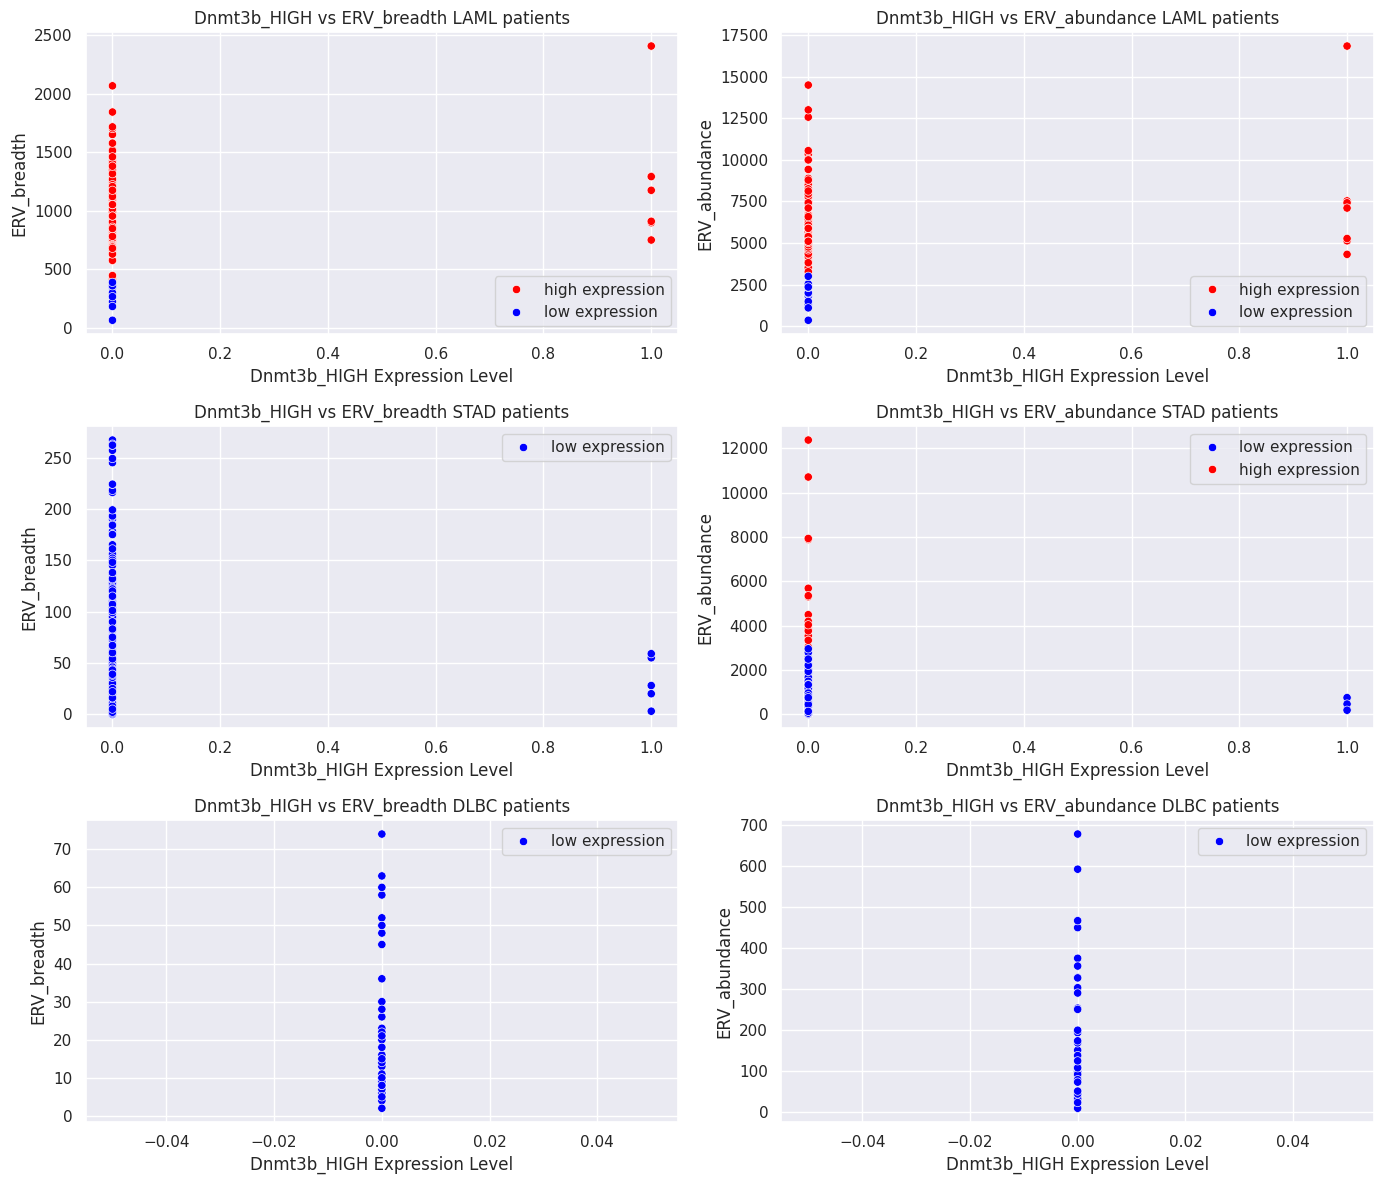

In [13]:
# Set a custom color palette
custom_palette = {"high expression": "red", "low expression": "blue"}

# Create a figure with multiple subplots
plt.figure(figsize=(14, 12))

# Dnmt3b_HIGH vs ERV_breadth
plt.subplot(3, 2, 1)
sns.scatterplot(data=LAML, x="Dnmt3b_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt3b_HIGH vs ERV_breadth LAML patients")
plt.xlabel("Dnmt3b_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt3b_HIGH vs ERV_abundance
plt.subplot(3, 2, 2)
sns.scatterplot(data=LAML, x="Dnmt3b_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3b_HIGH vs ERV_abundance LAML patients")
plt.xlabel("Dnmt3b_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Dnmt3b_MODERATE vs ERV_breadth
plt.subplot(3, 2, 3)
sns.scatterplot(data=STAD, x="Dnmt3b_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt3b_HIGH vs ERV_breadth STAD patients")
plt.xlabel("Dnmt3b_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt3b_MODERATE vs ERV_abundance
plt.subplot(3, 2, 4)
sns.scatterplot(data=STAD, x="Dnmt3b_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3b_HIGH vs ERV_abundance STAD patients")
plt.xlabel("Dnmt3b_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Dnmt3b_MODIFIER vs ERV_breadth
plt.subplot(3, 2, 5)
sns.scatterplot(data=DLBC, x="Dnmt3b_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt3b_HIGH vs ERV_breadth DLBC patients")
plt.xlabel("Dnmt3b_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt3b_MODIFIER vs ERV_abundance
plt.subplot(3, 2, 6)
sns.scatterplot(data=DLBC, x="Dnmt3b_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3b_HIGH vs ERV_abundance DLBC patients")
plt.xlabel("Dnmt3b_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [14]:
#cont how many patients with high impact mutation and high expression level 
he_hm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Dnmt3b_HIGH"] == 1)).sum()
le_hm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Dnmt3b_HIGH"] == 1)).sum()
he_lm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Dnmt3b_HIGH"] == 0)).sum()
le_lm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Dnmt3b_HIGH"] == 0)).sum()
print(he_hm, le_hm, he_lm, le_lm)

#perform the Chisq test
contingency_table = np.array([[le_hm, he_hm],[le_lm, he_lm]])
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print(f"Contingency Table (NumPy array):\n{contingency_table}")
print(f"\nChi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")



7 0 113 9
Contingency Table (NumPy array):
[[  0   7]
 [  9 113]]

Chi-square Statistic: 0.0
P-value: 1.0


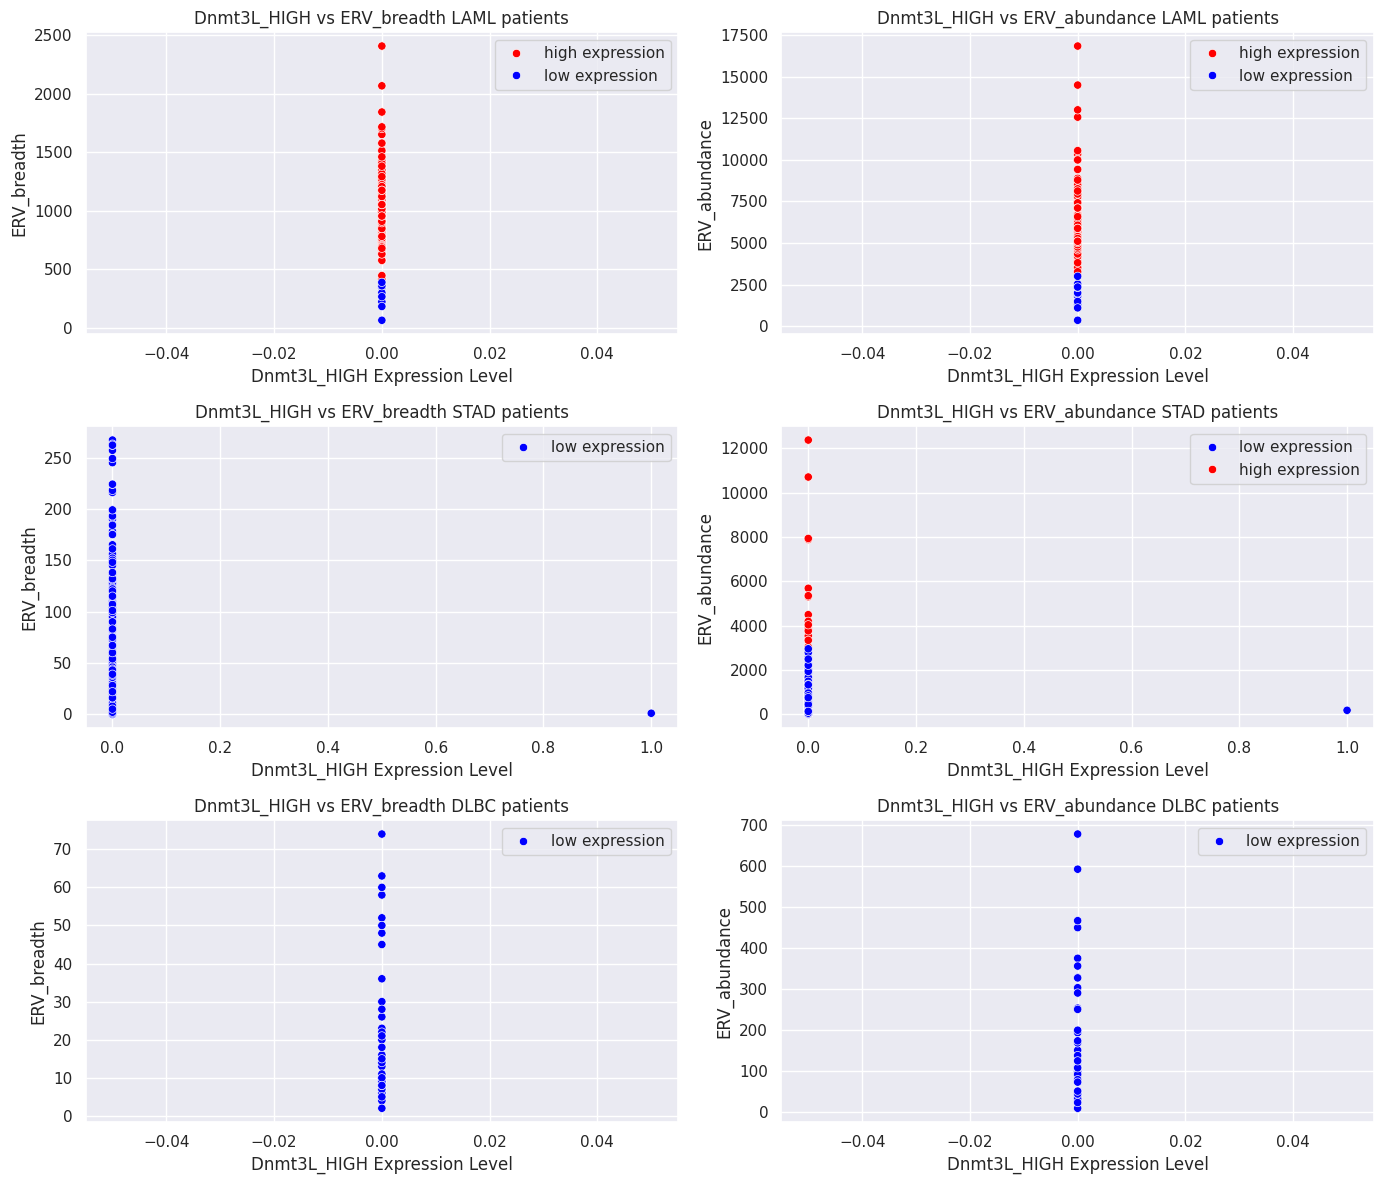

In [15]:
# Set a custom color palette
custom_palette = {"high expression": "red", "low expression": "blue"}

# Create a figure with multiple subplots
plt.figure(figsize=(14, 12))

# Dnmt3L_HIGH vs ERV_breadth
plt.subplot(3, 2, 1)
sns.scatterplot(data=LAML, x="Dnmt3L_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt3L_HIGH vs ERV_breadth LAML patients")
plt.xlabel("Dnmt3L_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt3L_HIGH vs ERV_abundance
plt.subplot(3, 2, 2)
sns.scatterplot(data=LAML, x="Dnmt3L_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3L_HIGH vs ERV_abundance LAML patients")
plt.xlabel("Dnmt3L_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Dnmt3L_MODERATE vs ERV_breadth
plt.subplot(3, 2, 3)
sns.scatterplot(data=STAD, x="Dnmt3L_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt3L_HIGH vs ERV_breadth STAD patients")
plt.xlabel("Dnmt3L_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt3L_MODERATE vs ERV_abundance
plt.subplot(3, 2, 4)
sns.scatterplot(data=STAD, x="Dnmt3L_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3L_HIGH vs ERV_abundance STAD patients")
plt.xlabel("Dnmt3L_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Dnmt3L_MODIFIER vs ERV_breadth
plt.subplot(3, 2, 5)
sns.scatterplot(data=DLBC, x="Dnmt3L_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Dnmt3L_HIGH vs ERV_breadth DLBC patients")
plt.xlabel("Dnmt3L_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Dnmt3L_MODIFIER vs ERV_abundance
plt.subplot(3, 2, 6)
sns.scatterplot(data=DLBC, x="Dnmt3L_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Dnmt3L_HIGH vs ERV_abundance DLBC patients")
plt.xlabel("Dnmt3L_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [17]:
#cont how many patients with high impact mutation and high expression level 
#he_hm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Dnmt3L_HIGH"] == 1)).sum()
#le_hm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Dnmt3L_HIGH"] == 1)).sum()
#he_lm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Dnmt3L_HIGH"] == 0)).sum()
#le_lm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Dnmt3L_HIGH"] == 0)).sum()
#print(he_hm, le_hm, he_lm, le_lm)

#perform the Chisq test
#contingency_table = np.array([[le_hm, he_hm],[le_lm, he_lm]])
#chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
#print(f"Contingency Table (NumPy array):\n{contingency_table}")
#print(f"\nChi-square Statistic: {chi2_stat}")
#print(f"P-value: {p_value}")



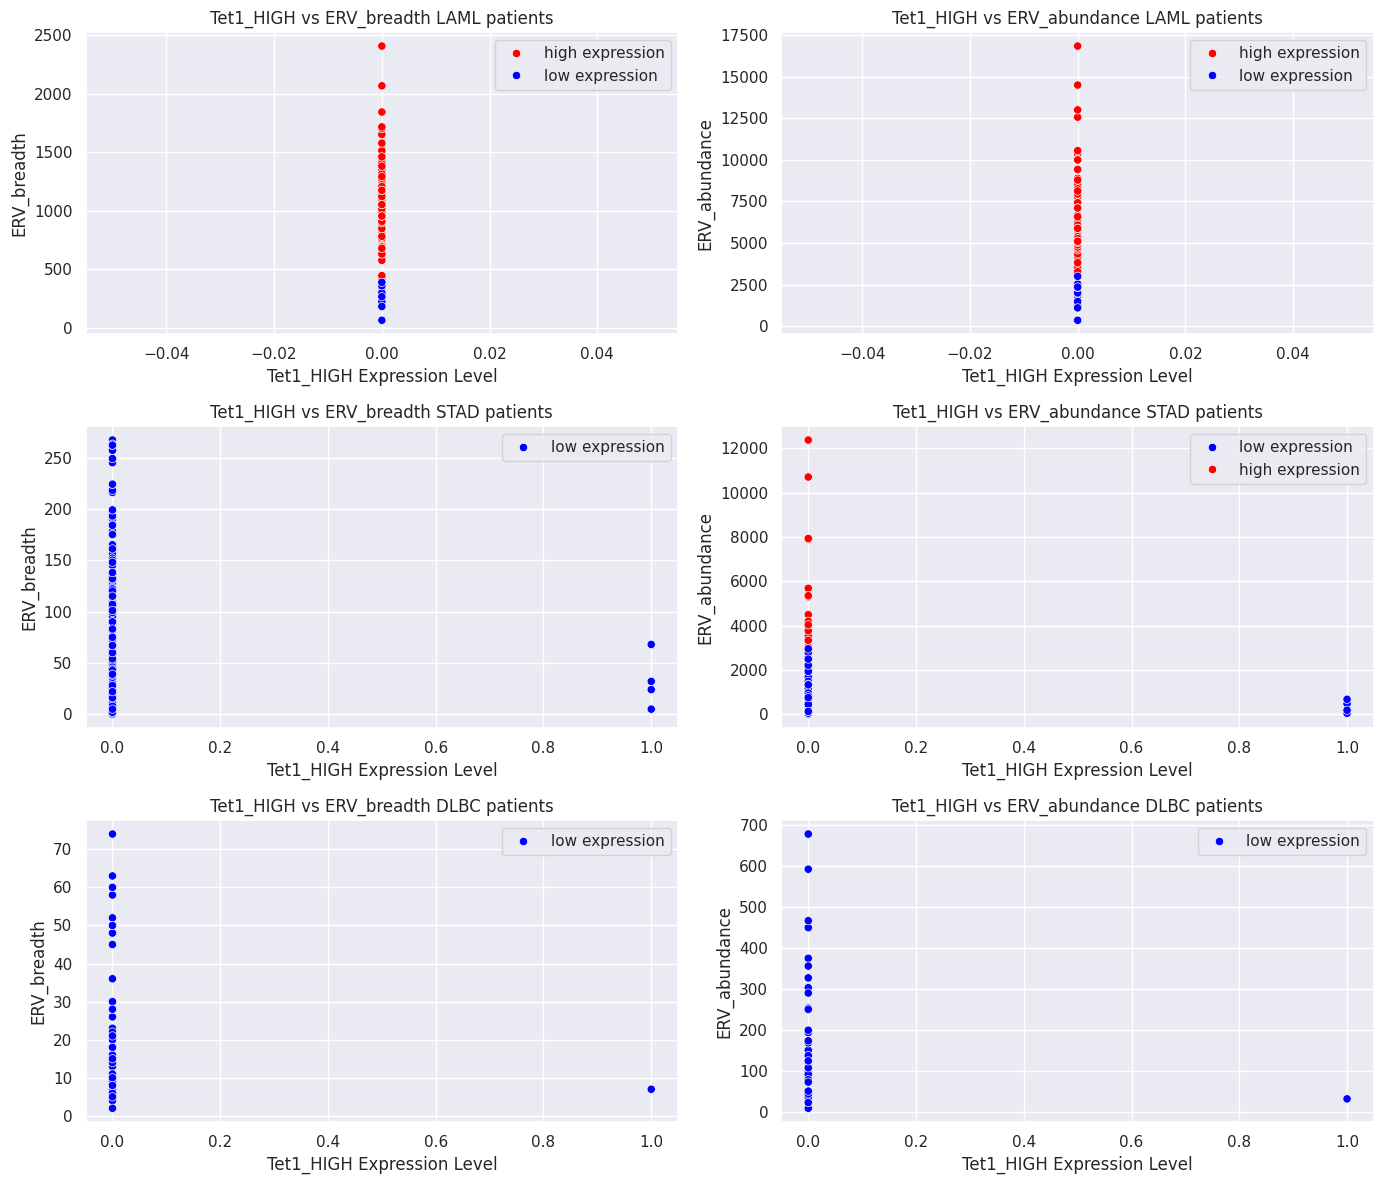

In [18]:
# Set a custom color palette
custom_palette = {"high expression": "red", "low expression": "blue"}

# Create a figure with multiple subplots
plt.figure(figsize=(14, 12))

# Tet1_HIGH vs ERV_breadth
plt.subplot(3, 2, 1)
sns.scatterplot(data=LAML, x="Tet1_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet1_HIGH vs ERV_breadth LAML patients")
plt.xlabel("Tet1_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet1_HIGH vs ERV_abundance
plt.subplot(3, 2, 2)
sns.scatterplot(data=LAML, x="Tet1_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet1_HIGH vs ERV_abundance LAML patients")
plt.xlabel("Tet1_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Tet1_MODERATE vs ERV_breadth
plt.subplot(3, 2, 3)
sns.scatterplot(data=STAD, x="Tet1_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet1_HIGH vs ERV_breadth STAD patients")
plt.xlabel("Tet1_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet1_MODERATE vs ERV_abundance
plt.subplot(3, 2, 4)
sns.scatterplot(data=STAD, x="Tet1_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet1_HIGH vs ERV_abundance STAD patients")
plt.xlabel("Tet1_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Tet1_MODIFIER vs ERV_breadth
plt.subplot(3, 2, 5)
sns.scatterplot(data=DLBC, x="Tet1_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet1_HIGH vs ERV_breadth DLBC patients")
plt.xlabel("Tet1_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet1_MODIFIER vs ERV_abundance
plt.subplot(3, 2, 6)
sns.scatterplot(data=DLBC, x="Tet1_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet1_HIGH vs ERV_abundance DLBC patients")
plt.xlabel("Tet1_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [20]:
#cont how many patients with high impact mutation and high expression level 
#he_hm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Tet1_HIGH"] > 0)).sum()
#le_hm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Tet1_HIGH"] > 0)).sum()
#he_lm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Tet1_HIGH"] == 0)).sum()
#le_lm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Tet1_HIGH"] == 0)).sum()
#print(he_hm, le_hm, he_lm, le_lm)

#perform the Chisq test
#contingency_table = np.array([[le_hm, he_hm],[le_lm, he_lm]])
#chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
#print(f"Contingency Table (NumPy array):\n{contingency_table}")
#print(f"\nChi-square Statistic: {chi2_stat}")
#print(f"P-value: {p_value}")


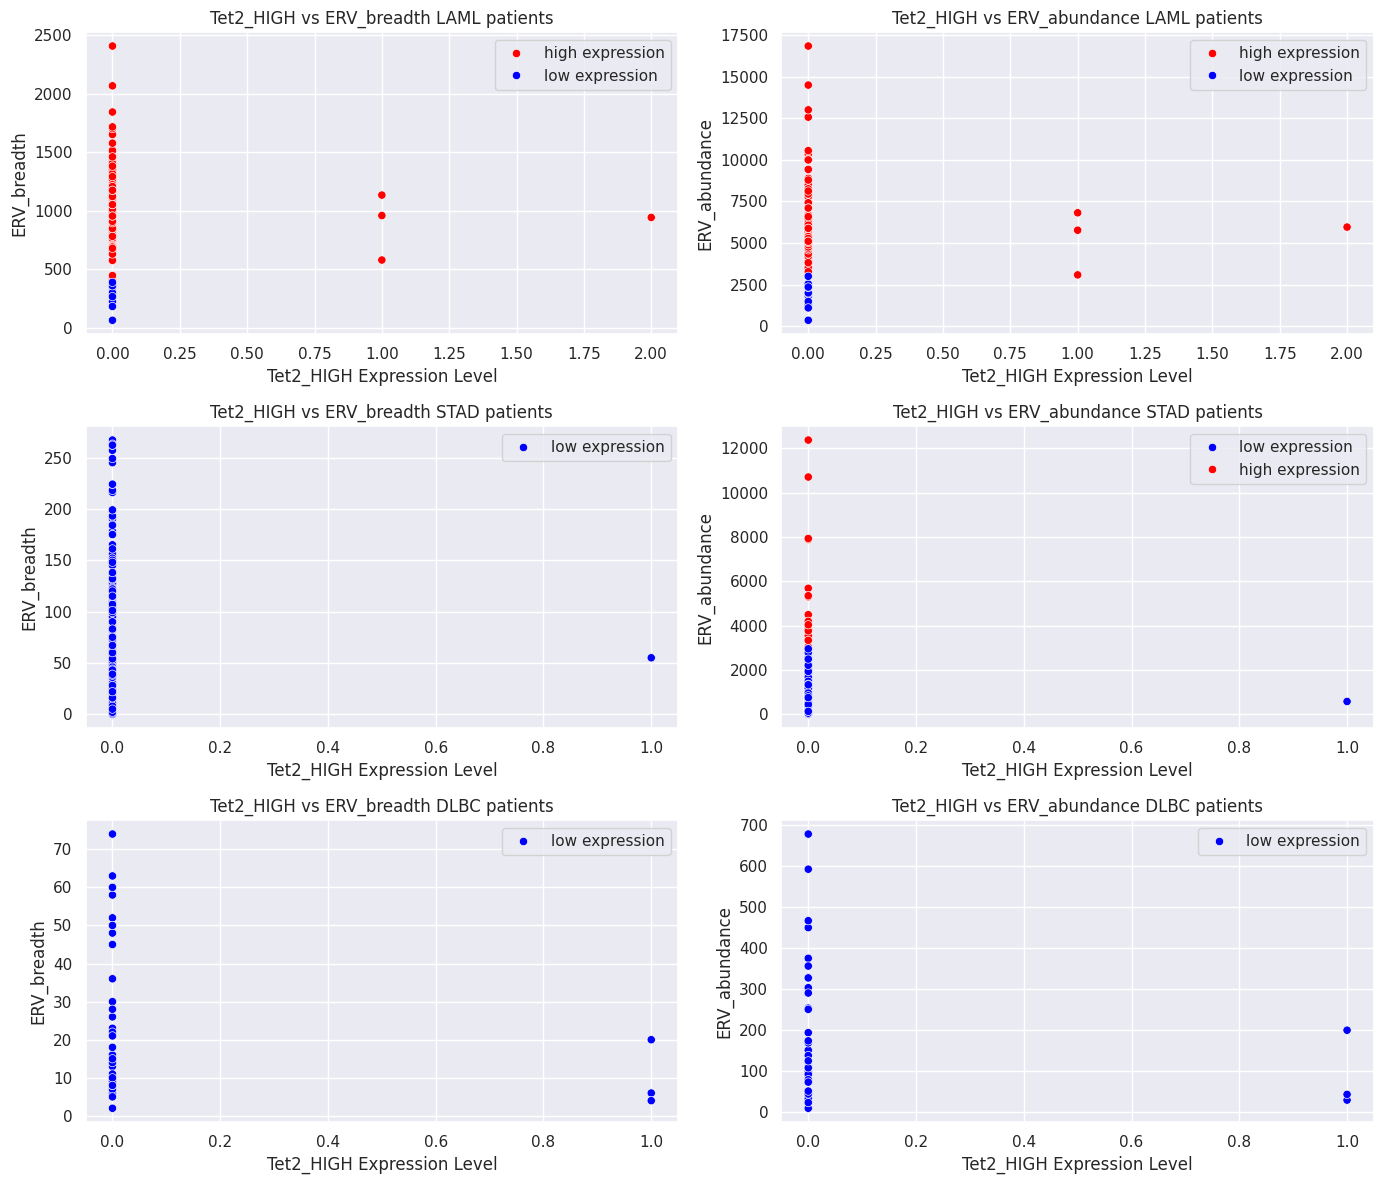

In [21]:
# Set a custom color palette
custom_palette = {"high expression": "red", "low expression": "blue"}

# Create a figure with multiple subplots
plt.figure(figsize=(14, 12))

# Tet2_HIGH vs ERV_breadth
plt.subplot(3, 2, 1)
sns.scatterplot(data=LAML, x="Tet2_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet2_HIGH vs ERV_breadth LAML patients")
plt.xlabel("Tet2_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet2_HIGH vs ERV_abundance
plt.subplot(3, 2, 2)
sns.scatterplot(data=LAML, x="Tet2_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet2_HIGH vs ERV_abundance LAML patients")
plt.xlabel("Tet2_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Tet2_MODERATE vs ERV_breadth
plt.subplot(3, 2, 3)
sns.scatterplot(data=STAD, x="Tet2_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet2_HIGH vs ERV_breadth STAD patients")
plt.xlabel("Tet2_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet2_MODERATE vs ERV_abundance
plt.subplot(3, 2, 4)
sns.scatterplot(data=STAD, x="Tet2_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet2_HIGH vs ERV_abundance STAD patients")
plt.xlabel("Tet2_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Tet2_MODIFIER vs ERV_breadth
plt.subplot(3, 2, 5)
sns.scatterplot(data=DLBC, x="Tet2_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet2_HIGH vs ERV_breadth DLBC patients")
plt.xlabel("Tet2_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet2_MODIFIER vs ERV_abundance
plt.subplot(3, 2, 6)
sns.scatterplot(data=DLBC, x="Tet2_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet2_HIGH vs ERV_abundance DLBC patients")
plt.xlabel("Tet2_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [22]:
#cont how many patients with high impact mutation and high expression level 
#he_hm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Tet2_HIGH"] > 0)).sum()
#le_hm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Tet2_HIGH"] > 0)).sum()
#he_lm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Tet2_HIGH"] == 0)).sum()
#le_lm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Tet2_HIGH"] == 0)).sum()
#print(he_hm, le_hm, he_lm, le_lm)

#perform the Chisq test
#contingency_table = np.array([[le_hm, he_hm],[le_lm, he_lm]])
#chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
#print(f"Contingency Table (NumPy array):\n{contingency_table}")
#print(f"\nChi-square Statistic: {chi2_stat}")
#print(f"P-value: {p_value}")


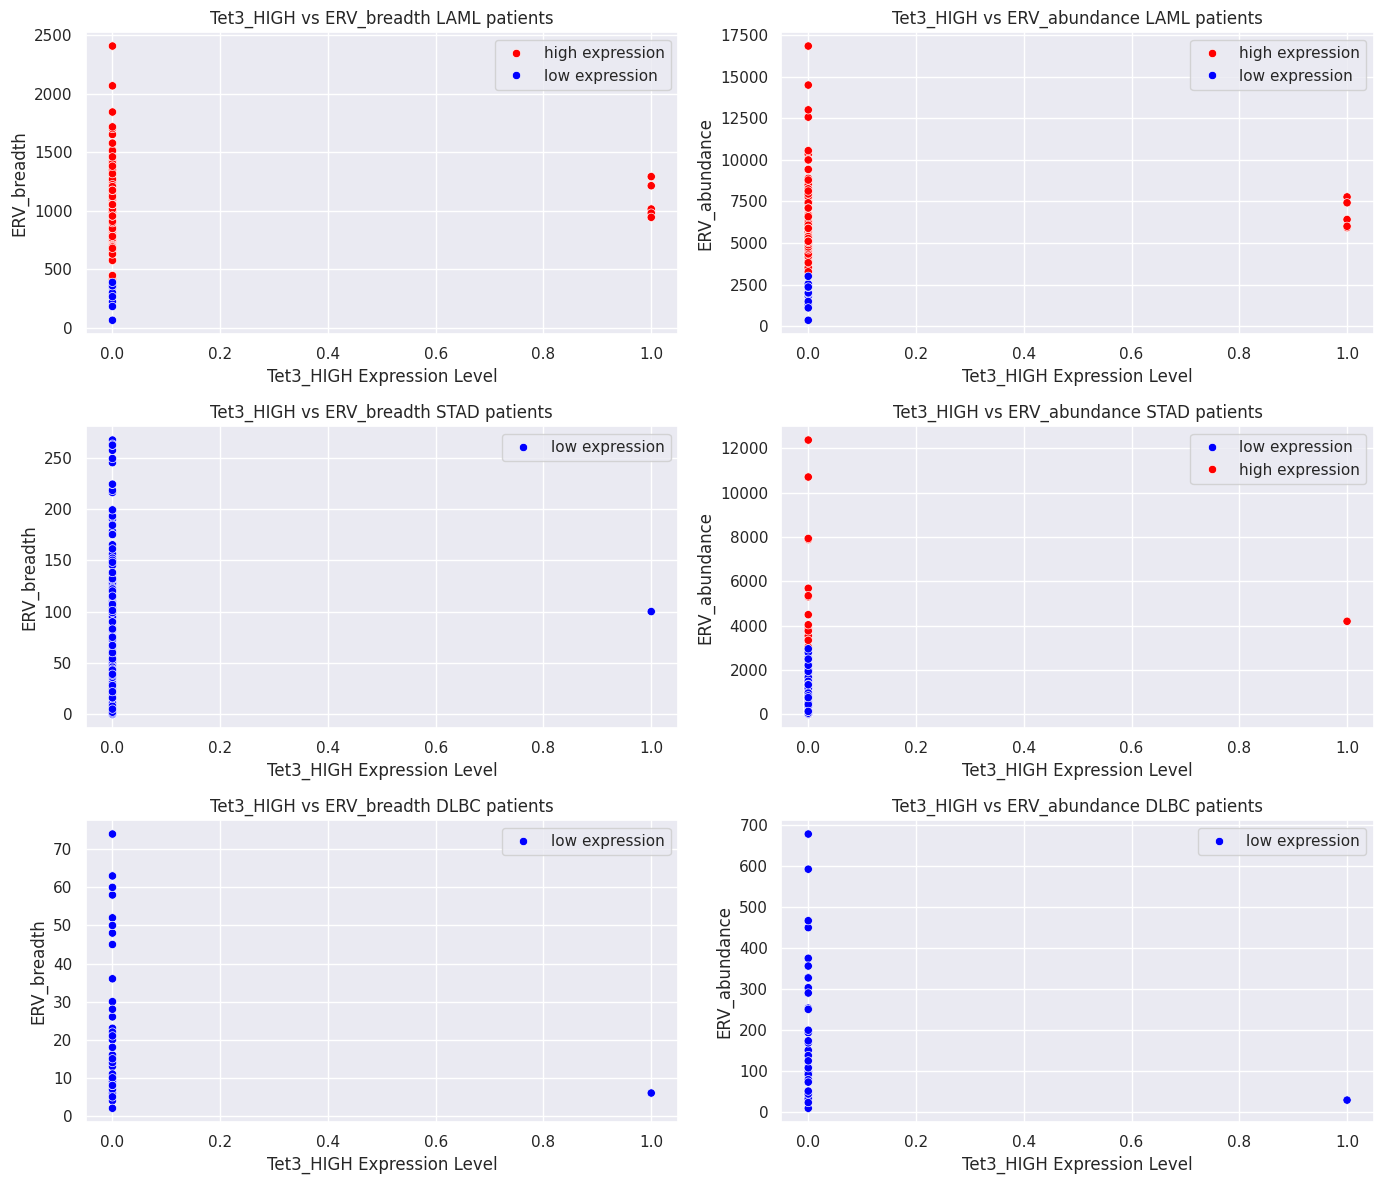

In [23]:
# Set a custom color palette
custom_palette = {"high expression": "red", "low expression": "blue"}

# Create a figure with multiple subplots
plt.figure(figsize=(14, 12))

# Tet3_HIGH vs ERV_breadth
plt.subplot(3, 2, 1)
sns.scatterplot(data=LAML, x="Tet3_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet3_HIGH vs ERV_breadth LAML patients")
plt.xlabel("Tet3_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet3_HIGH vs ERV_abundance
plt.subplot(3, 2, 2)
sns.scatterplot(data=LAML, x="Tet3_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet3_HIGH vs ERV_abundance LAML patients")
plt.xlabel("Tet3_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Tet3_MODERATE vs ERV_breadth
plt.subplot(3, 2, 3)
sns.scatterplot(data=STAD, x="Tet3_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet3_HIGH vs ERV_breadth STAD patients")
plt.xlabel("Tet3_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet3_MODERATE vs ERV_abundance
plt.subplot(3, 2, 4)
sns.scatterplot(data=STAD, x="Tet3_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet3_HIGH vs ERV_abundance STAD patients")
plt.xlabel("Tet3_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Tet3_MODIFIER vs ERV_breadth
plt.subplot(3, 2, 5)
sns.scatterplot(data=DLBC, x="Tet3_HIGH", y="ERV_breadth", hue="high_expr_breadth", palette=custom_palette)
plt.title("Tet3_HIGH vs ERV_breadth DLBC patients")
plt.xlabel("Tet3_HIGH Expression Level")
plt.ylabel("ERV_breadth")
plt.legend()

# Tet3_MODIFIER vs ERV_abundance
plt.subplot(3, 2, 6)
sns.scatterplot(data=DLBC, x="Tet3_HIGH", y="ERV_abundance", hue="high_expr_abundance", palette=custom_palette)
plt.title("Tet3_HIGH vs ERV_abundance DLBC patients")
plt.xlabel("Tet3_HIGH Expression Level")
plt.ylabel("ERV_abundance")
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [24]:
#cont how many patients with high impact mutation and high expression level 
#he_hm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Tet3_HIGH"] > 0)).sum()
#le_hm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Tet3_HIGH"] > 0)).sum()
#he_lm = ((LAML['high_expr_breadth'] == 'high expression') & (LAML["Tet3_HIGH"] == 0)).sum()
#le_lm = ((LAML['high_expr_breadth'] == 'low expression') & (LAML["Tet3_HIGH"] == 0)).sum()
#print(he_hm, le_hm, he_lm, le_lm)

#perform the Chisq test
#contingency_table = np.array([[le_hm, he_hm],[le_lm, he_lm]])
#chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
#print(f"Contingency Table (NumPy array):\n{contingency_table}")
#print(f"\nChi-square Statistic: {chi2_stat}")
#print(f"P-value: {p_value}")


In [86]:
#redo the df 
#print(LAML.info())
#print(LAML.head())
%matplotlib inline 

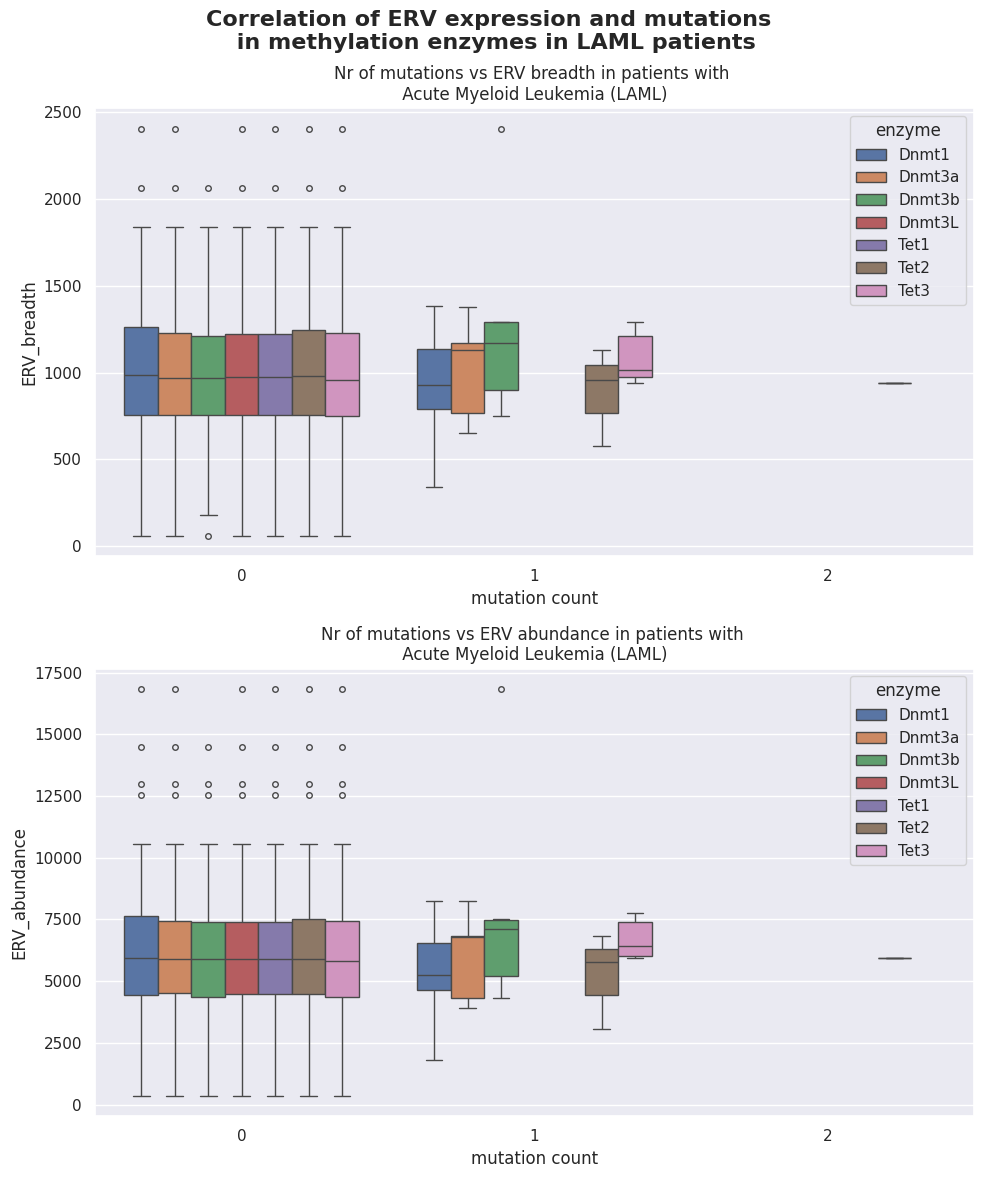

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def fill_count_column(full_df, filename, enzyme):
    # find the mutation column for the enzyme:
    column = enzyme + '_HIGH'
    # get the value
    return full_df.loc[full_df['filename'] == filename, column].values[0]

enzyme_columns = ['Dnmt1', 'Dnmt3a', 'Dnmt3b', 'Dnmt3L', 'Tet1', 'Tet2', 'Tet3']

# Assuming 'LAML' is your DataFrame
LAML_melt = pd.melt(LAML, id_vars=['cancer_type', 'high_expr_abundance', 'patient_ID_expr', 'ERV_abundance', 'ERV_breadth', 'filename', 'patient_ID', 'total_mut'], value_vars=enzyme_columns, var_name='enzyme', value_name='mutation count')

# Use correct DataFrame name in the loop
for index, row in LAML_melt.iterrows():
    filename = row['filename']
    enzyme = row['enzyme']
    LAML_melt.at[index, 'mutation count'] = fill_count_column(LAML, filename, enzyme)

plt.figure(figsize=(10, 12))

# Box plot grouping by enzyme
plt.subplot(2,1,1)
sns.boxplot(data=LAML_melt, y='ERV_breadth', x="mutation count", hue="enzyme", fliersize=4)
plt.title("Nr of mutations vs ERV breadth in patients with \n Acute Myeloid Leukemia (LAML) ")

plt.subplot(2,1,2)
sns.boxplot(data=LAML_melt, y='ERV_abundance', x="mutation count", hue="enzyme", fliersize=4)
plt.title("Nr of mutations vs ERV abundance in patients with \n Acute Myeloid Leukemia (LAML) ")

plt.suptitle("Correlation of ERV expression and mutations \n in methylation enzymes in LAML patients", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig('LAML.jpg')
plt.show()


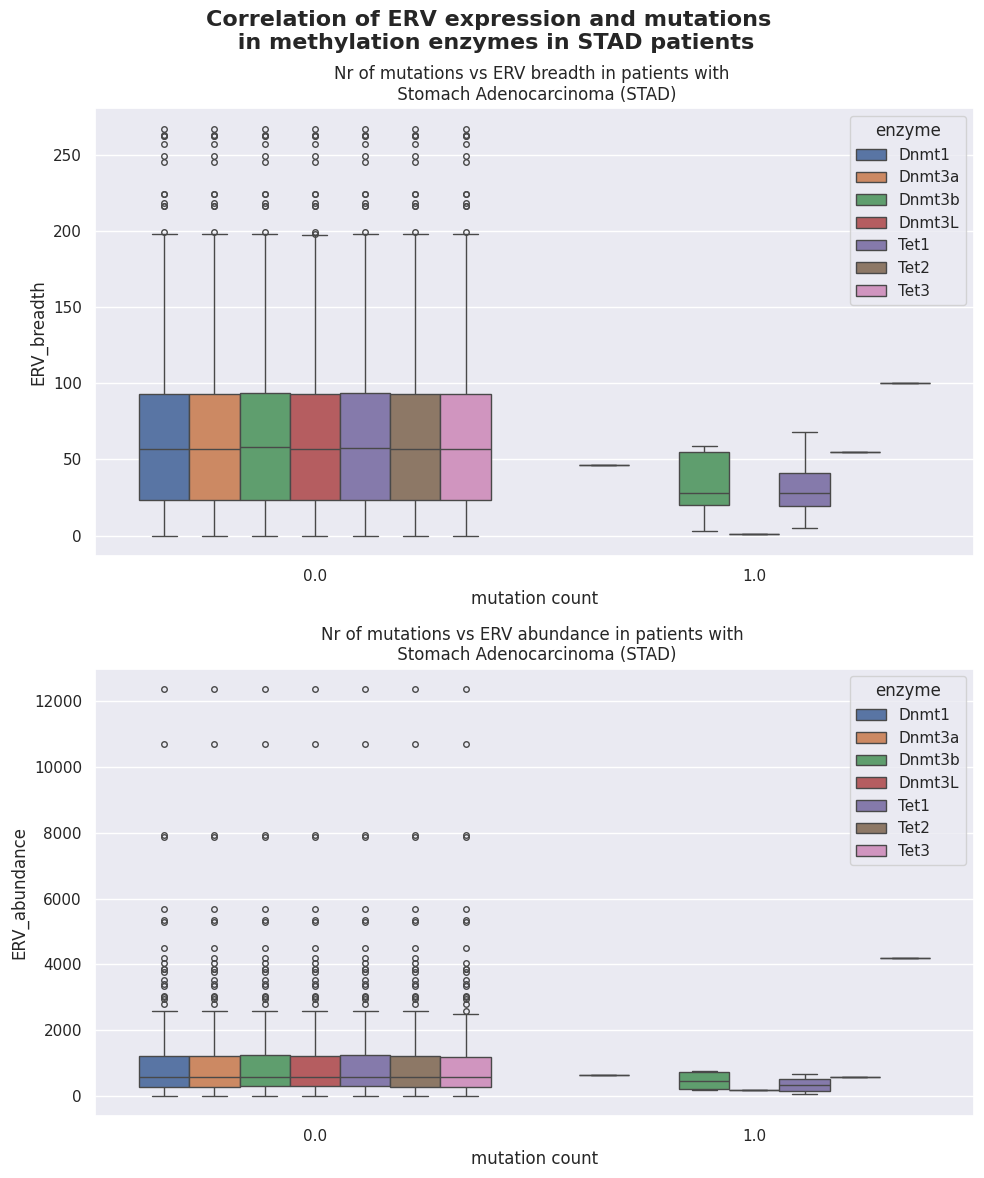

In [23]:
STAD_melt = pd.melt(STAD, id_vars=['cancer_type', 'high_expr_abundance', 'patient_ID_expr', 'ERV_abundance', 'ERV_breadth', 'filename', 'patient_ID', 'total_mut'], value_vars=enzyme_columns, var_name='enzyme', value_name='mutatuon count')

# Use correct DataFrame name in the loop
for index, row in STAD_melt.iterrows():
    filename = row['filename']
    enzyme = row['enzyme']
    STAD_melt.at[index, 'mutation count'] = fill_count_column(STAD, filename, enzyme)

plt.figure(figsize=(10, 12))

# Box plot grouping by enzyme
plt.subplot(2,1,1)
sns.boxplot(data=STAD_melt, y='ERV_breadth', x="mutation count", hue="enzyme", fliersize=4)
plt.title("Nr of mutations vs ERV breadth in patients with \n Stomach Adenocarcinoma (STAD)")

plt.subplot(2,1,2)
sns.boxplot(data=STAD_melt, y='ERV_abundance', x="mutation count", hue="enzyme", fliersize=4)
plt.title("Nr of mutations vs ERV abundance in patients with \n Stomach Adenocarcinoma (STAD)")

plt.suptitle("Correlation of ERV expression and mutations \n in methylation enzymes in STAD patients", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig('STAD.jpg')
plt.show()


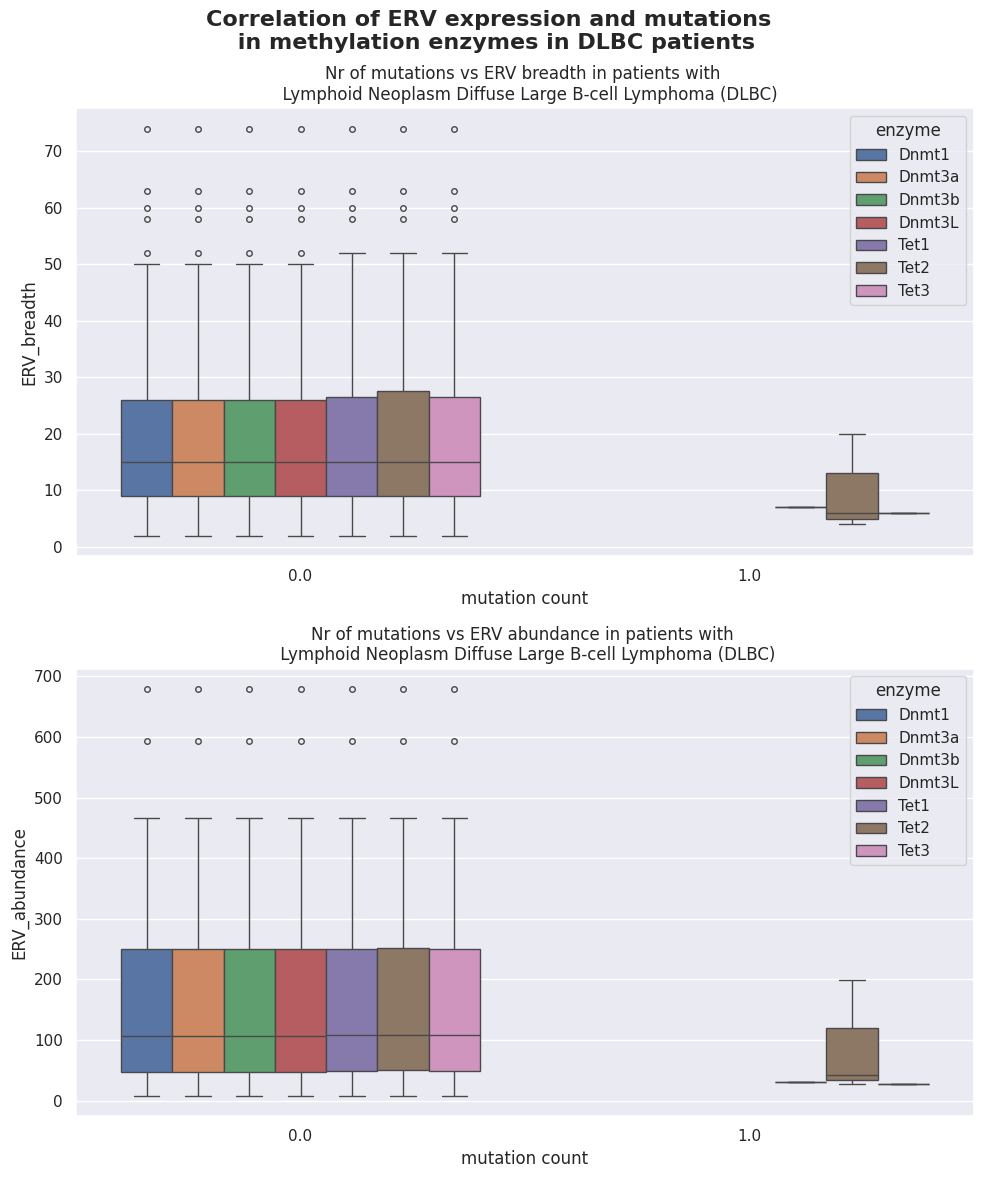

In [24]:
DLBC_melt = pd.melt(DLBC, id_vars=['cancer_type', 'high_expr_abundance', 'patient_ID_expr', 'ERV_abundance', 'ERV_breadth', 'filename', 'patient_ID', 'total_mut'], value_vars=enzyme_columns, var_name='enzyme', value_name='count')

# Use correct DataFrame name in the loop
for index, row in DLBC_melt.iterrows():
    filename = row['filename']
    enzyme = row['enzyme']
    DLBC_melt.at[index, 'mutation count'] = fill_count_column(DLBC, filename, enzyme)

plt.figure(figsize=(10, 12))

# Box plot grouping by enzyme
plt.subplot(2,1,1)
sns.boxplot(data=DLBC_melt, y='ERV_breadth', x="mutation count", hue="enzyme", fliersize=4)
plt.title("Nr of mutations vs ERV breadth in patients with \n  Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC)")

plt.subplot(2,1,2)
sns.boxplot(data=DLBC_melt, y='ERV_abundance', x="mutation count", hue="enzyme", fliersize=4)
plt.title("Nr of mutations vs ERV abundance in patients with \n Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC)")

plt.suptitle("Correlation of ERV expression and mutations \n in methylation enzymes in DLBC patients", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig('DLBC.jpg')
plt.show()

